In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
def correct_results( entry, column ):
    a = entry.loc[entry["kind"].str.startswith("actual")]
    n = entry.loc[entry["kind"].str.startswith("null")]
    n = n.groupby( ["siteA", "siteB", "date"] )[column].agg(
        null_upper=lambda x: x.quantile( 0.975 ),
        null_lower=lambda x: x.quantile( 0.025 ),
        null_median="median",
        null_mean="mean",
        null_std="std" )
    a = a.merge( n, left_on=["siteA", "siteB", "date"], right_index=True, validate="1:1" )
    a["corrected_sub"] = a["null_upper"] - a[column]
    a["corrected_z"] = (a["null_upper"] - a[column]) / a["null_std"]
    return a

In [2]:
min_sequences = 1

res = pd.read_csv( "../resources/phylosor_newnull_results.csv", parse_dates=["date"] )
res = res.loc[res["siteA"]=="San Diego_CA"]
res = res.loc[(res["countA"]>min_sequences)&(res["countB"]>min_sequences)]
res["kind"] = res["kind"].fillna( "null" )
res["kind"] = res["kind"] + res["num"].astype( str )
res = res.drop( columns=["num"] )

# Phylosor Norm

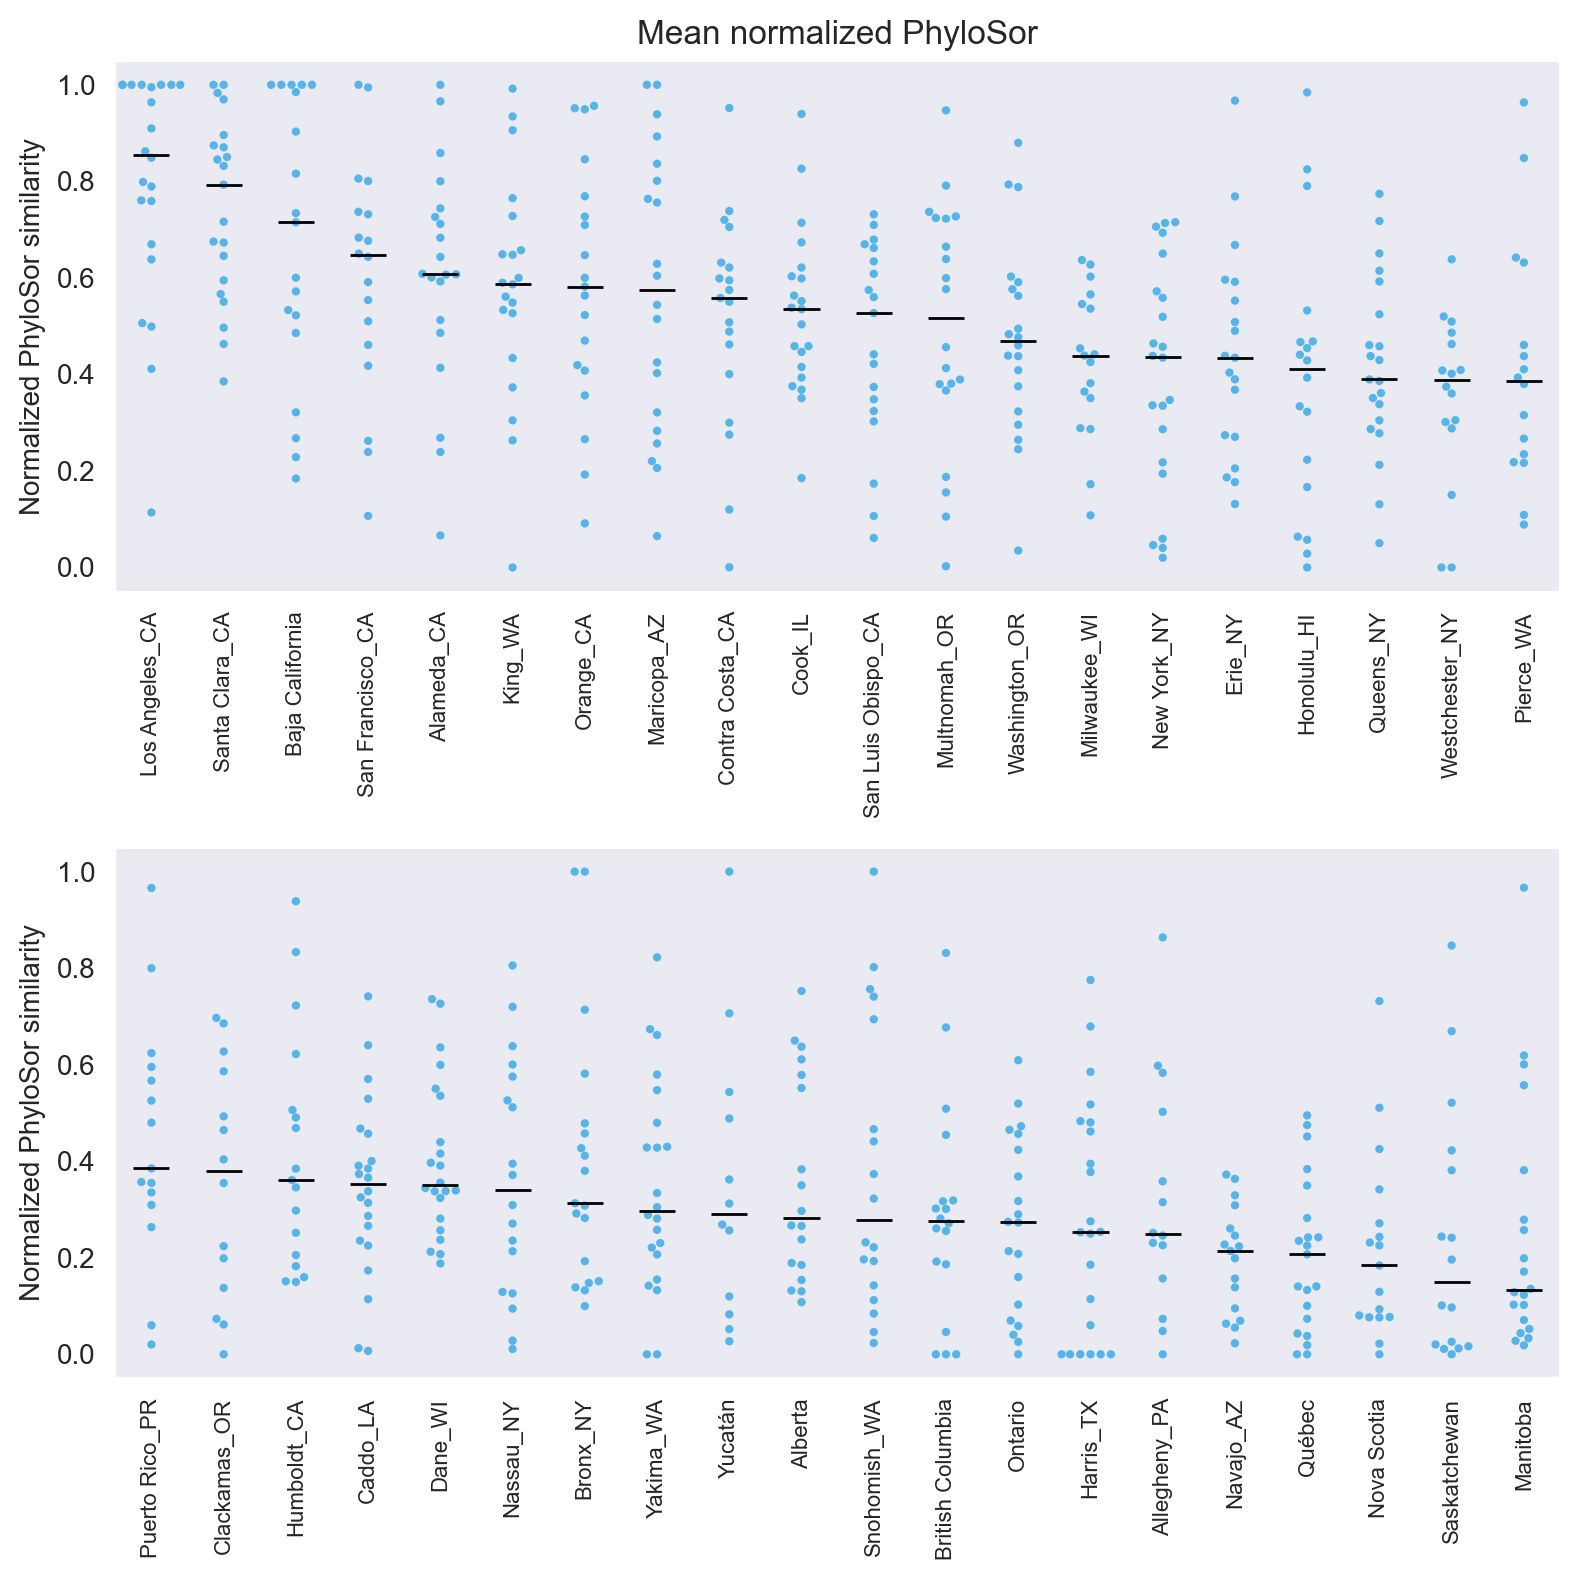

In [6]:
raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
raw = raw.reindex(index=raw.median(axis=1).sort_values( ascending=False ).index)

orders = (raw-raw.min())/(raw.max()-raw.min())
orders = orders.reindex( index=orders.median( axis=1 ).sort_values( ascending=False ).index )

plot_df = orders.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_df2 = orders.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Normalized PhyloSor similarity" )
ax[0].set_xlabel( "" )
ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Normalized PhyloSor similarity" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1, color="black" )

plt.tight_layout()
plt.savefig( f"phylosor_norm.pdf" )
plt.show()

# Temporal similarity

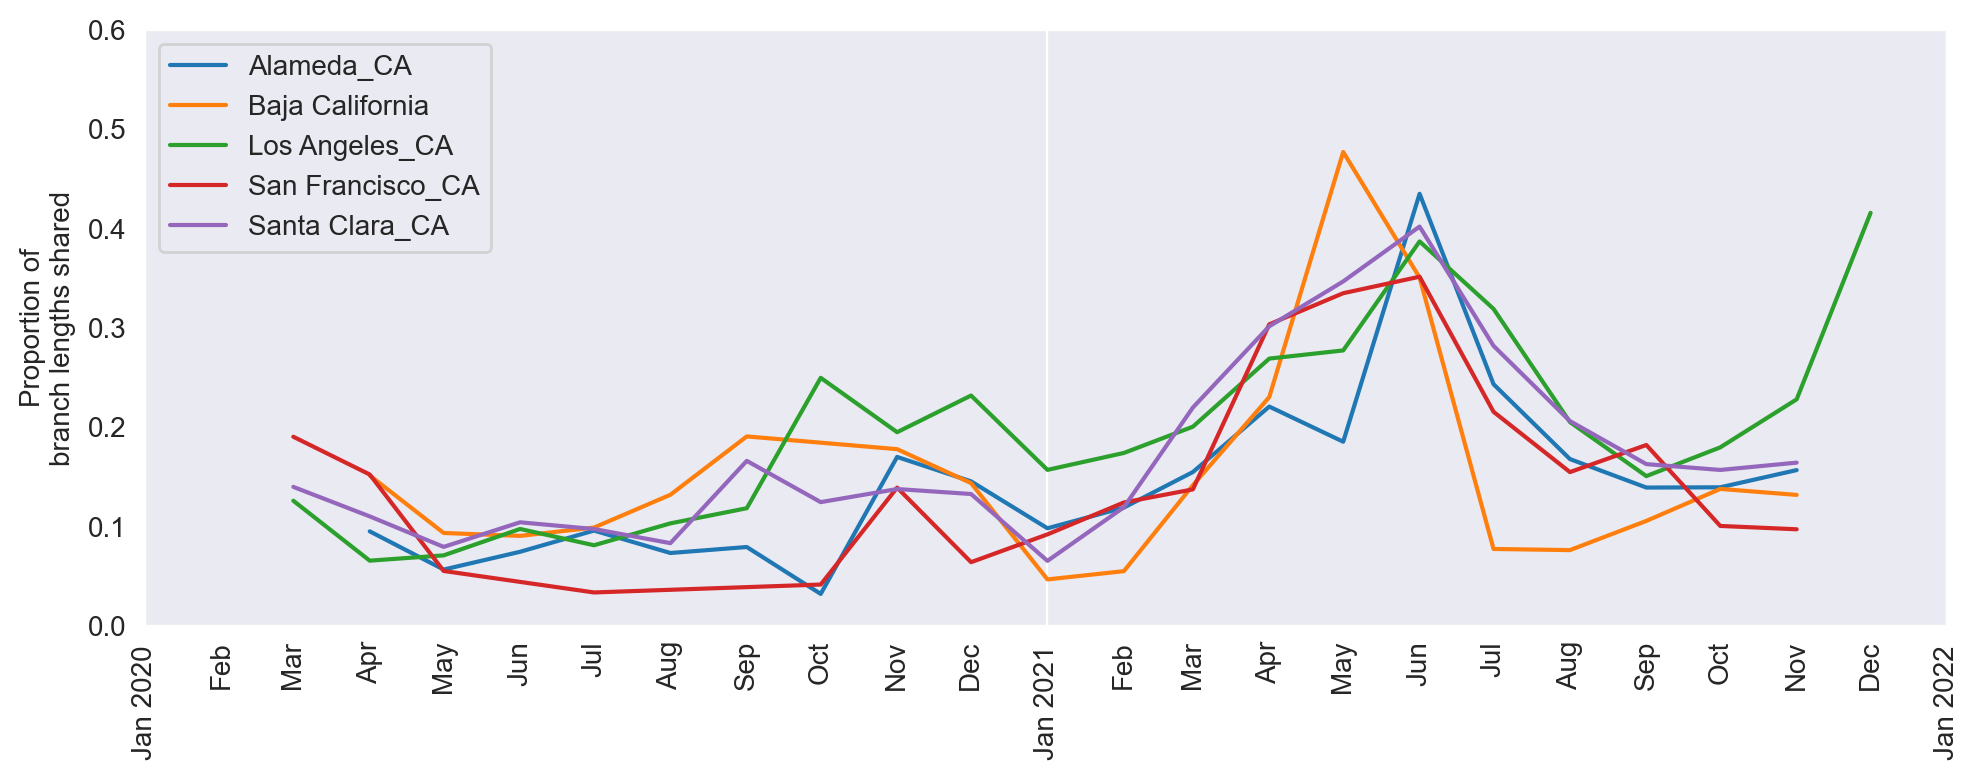

In [7]:
plot_df = res.loc[(res["kind"]=="actual1")&(res["siteB"].isin( orders.index[:5]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "value", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 0.6 )
ax.set_ylabel( "Proportion of\nbranch lengths shared")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
#plt.savefig( "top_phylosor.pdf" )
plt.show()

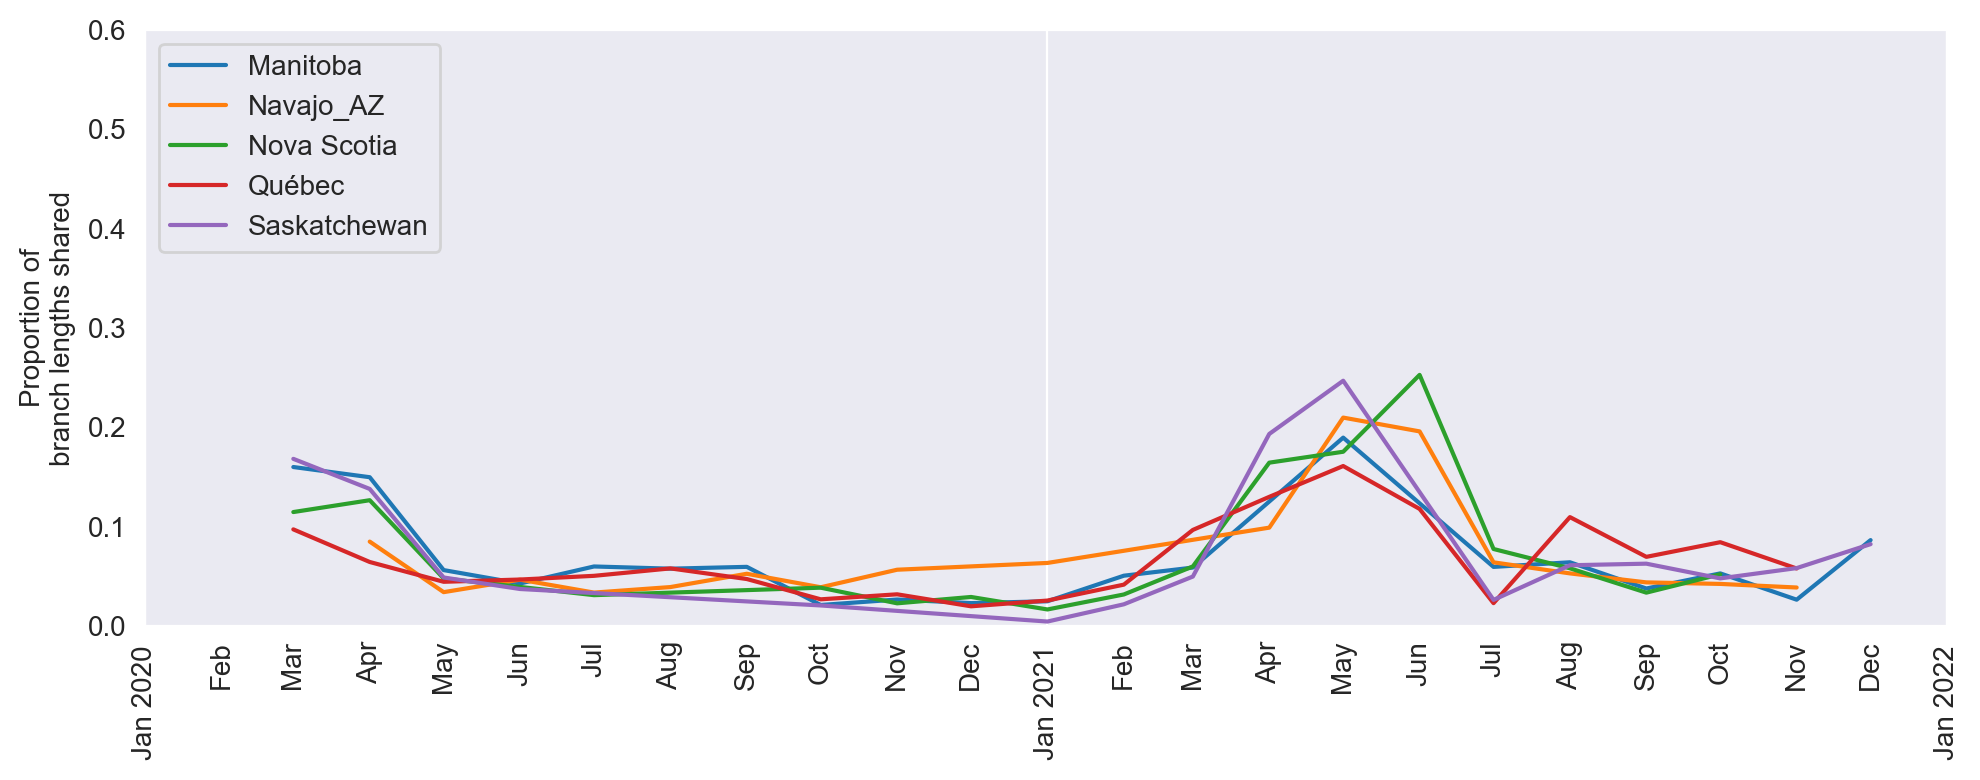

In [8]:
plot_df = res.loc[(res["kind"]=="actual1")&(res["siteB"].isin( orders.index[-5:]))]

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
for name, entry in plot_df.groupby( "siteB" ):
    ax.plot( "date", "value", data=entry, label=name, zorder=100 )
ax.legend(loc="upper left")
ax.xaxis.set_major_locator( mdates.YearLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax.xaxis.set_minor_locator( mdates.MonthLocator() )
ax.xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax.tick_params( axis="x", which="both", rotation=90 )
ax.set_xlim( ( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ) )
ax.set_ylim( 0, 0.6 )
ax.set_ylabel( "Proportion of\nbranch lengths shared")
ax.grid( axis="y", zorder=0 )
plt.tight_layout()
#plt.savefig( "bottom_phylosor.pdf" )
plt.show()

In [74]:
first_wave = ["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01"] # ("2020-01-01","2020-08-15")
second_wave = ( "2020-11-01", "2021-03-02" )
third_wave = ( "2021-07-01", "2022-03-02" )

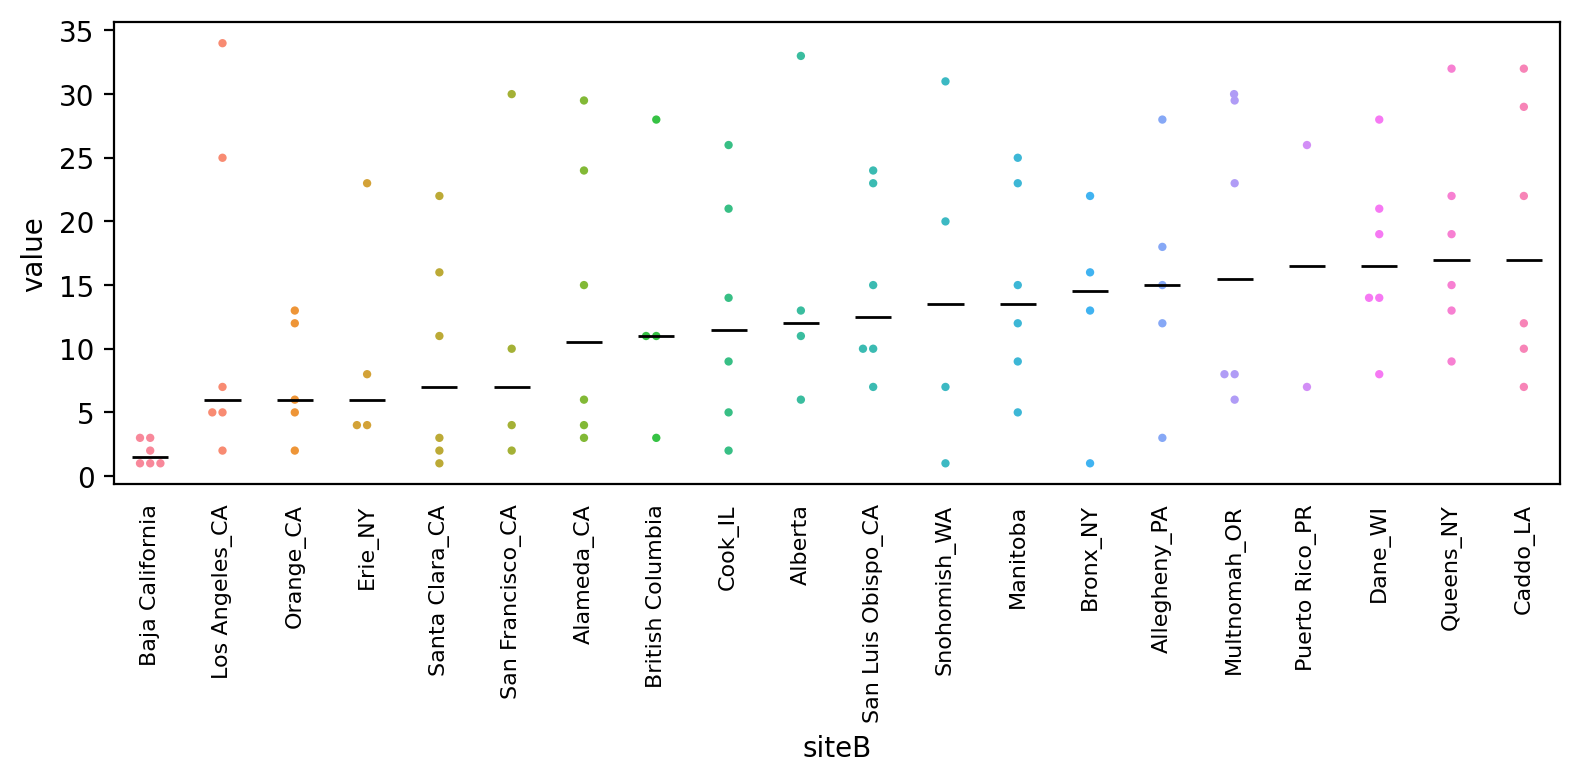

In [88]:
plot_df = orders[first_wave]
plot_mean = plot_df.median( axis=1 ).sort_values().reset_index().reset_index()
plot_df = plot_df.reindex( index=plot_mean["siteB"] )
plot_df = plot_df.iloc[:20].melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,4) )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax )
ax.hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax.tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
plt.tight_layout()
plt.show()

# Mean difference to mixed model

In [35]:
cor.loc[cor.index.isin( orders.index[:5] )]

date,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,...,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
siteB,,,,,,,,,,,,,,,,,,,,,
Alameda_CA,0.134190,0.111702,0.106624,0.120340,0.086991,0.091351,0.130219,0.116837,0.100973,0.083785,...,0.175685,0.179753,0.349429,0.170634,0.162418,0.156985,0.176734,0.156666,0.170009,NaN
Baja California,0.000000,0.069836,0.051736,0.087405,0.079207,0.076621,0.098129,0.005414,0.095571,0.067946,...,0.090104,0.081235,0.036748,0.118484,0.039189,0.018890,0.131667,0.121490,0.125121,NaN
Los Angeles_CA,0.068282,0.082784,0.040256,0.053568,0.092229,0.178945,0.109032,0.147481,0.114241,0.073460,...,0.119073,0.143945,0.216299,0.136276,0.126854,0.115255,0.127775,0.155020,0.180839,0.040967
San Francisco_CA,0.025118,0.101771,0.052701,NaN,0.046703,NaN,0.048708,0.017521,0.041245,0.060828,...,0.209246,0.093185,0.164316,0.226834,0.109672,0.131654,0.163764,0.127102,0.105144,0.050359
Santa Clara_CA,0.109796,0.166722,0.084858,0.091754,0.063715,0.052053,0.090728,0.113539,0.130517,0.090318,...,0.067852,0.053350,0.150006,0.207436,0.160159,0.196545,0.181422,0.210099,0.244795,NaN


In [104]:
correct_results( res, "value" ).sort_values("null_std", ascending=False )

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,kind,null_upper,null_lower,null_median,null_mean,null_std,corrected_sub,corrected_z
8957,0.021302,0.003110,0.001438,2021-06-01,San Diego_CA,60,Québec,12,0.117808,0.462366,actual1,0.518464,0.256299,0.426832,0.414140,0.096120,0.400656,4.168306
9508,0.021302,0.010166,0.005418,2021-06-01,San Diego_CA,60,Bronx_NY,13,0.344315,0.532895,actual1,0.563206,0.303940,0.490885,0.480295,0.087080,0.218891,2.513669
9045,0.011905,0.006220,0.003143,2021-05-01,San Diego_CA,31,Santa Clara_CA,6,0.346864,0.505376,actual1,0.496869,0.259750,0.416719,0.392308,0.084935,0.150006,1.766115
9383,0.002943,0.001037,0.000301,2020-03-01,San Diego_CA,32,Milwaukee_WI,32,0.151261,0.290323,actual1,0.367634,0.154727,0.203813,0.232204,0.082283,0.216374,2.629617
9222,0.021302,0.004916,0.003210,2021-06-01,San Diego_CA,60,Contra Costa_CA,9,0.244898,0.653061,actual1,0.437660,0.249133,0.378066,0.354624,0.076650,0.192762,2.514846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,0.240411,0.572651,0.035147,2021-01-01,San Diego_CA,1121,Harris_TX,2487,0.086456,0.146196,actual1,0.226855,0.213995,0.221695,0.221375,0.003982,0.140399,35.255964
8916,0.178210,0.180617,0.024713,2021-10-01,San Diego_CA,1366,New York_NY,1262,0.137745,0.138675,actual1,0.389668,0.378203,0.382090,0.382226,0.003824,0.251923,65.872182
9441,0.011905,0.008895,0.003745,2021-05-01,San Diego_CA,31,Yucatán,34,0.360129,0.421053,actual1,0.368249,0.360129,0.360129,0.361177,0.003314,0.008121,2.450765
9265,0.011905,0.009263,0.002006,2021-05-01,San Diego_CA,31,Manitoba,25,0.189573,0.216607,actual1,0.189573,0.189573,0.189573,0.189573,0.000000,0.000000,NaN


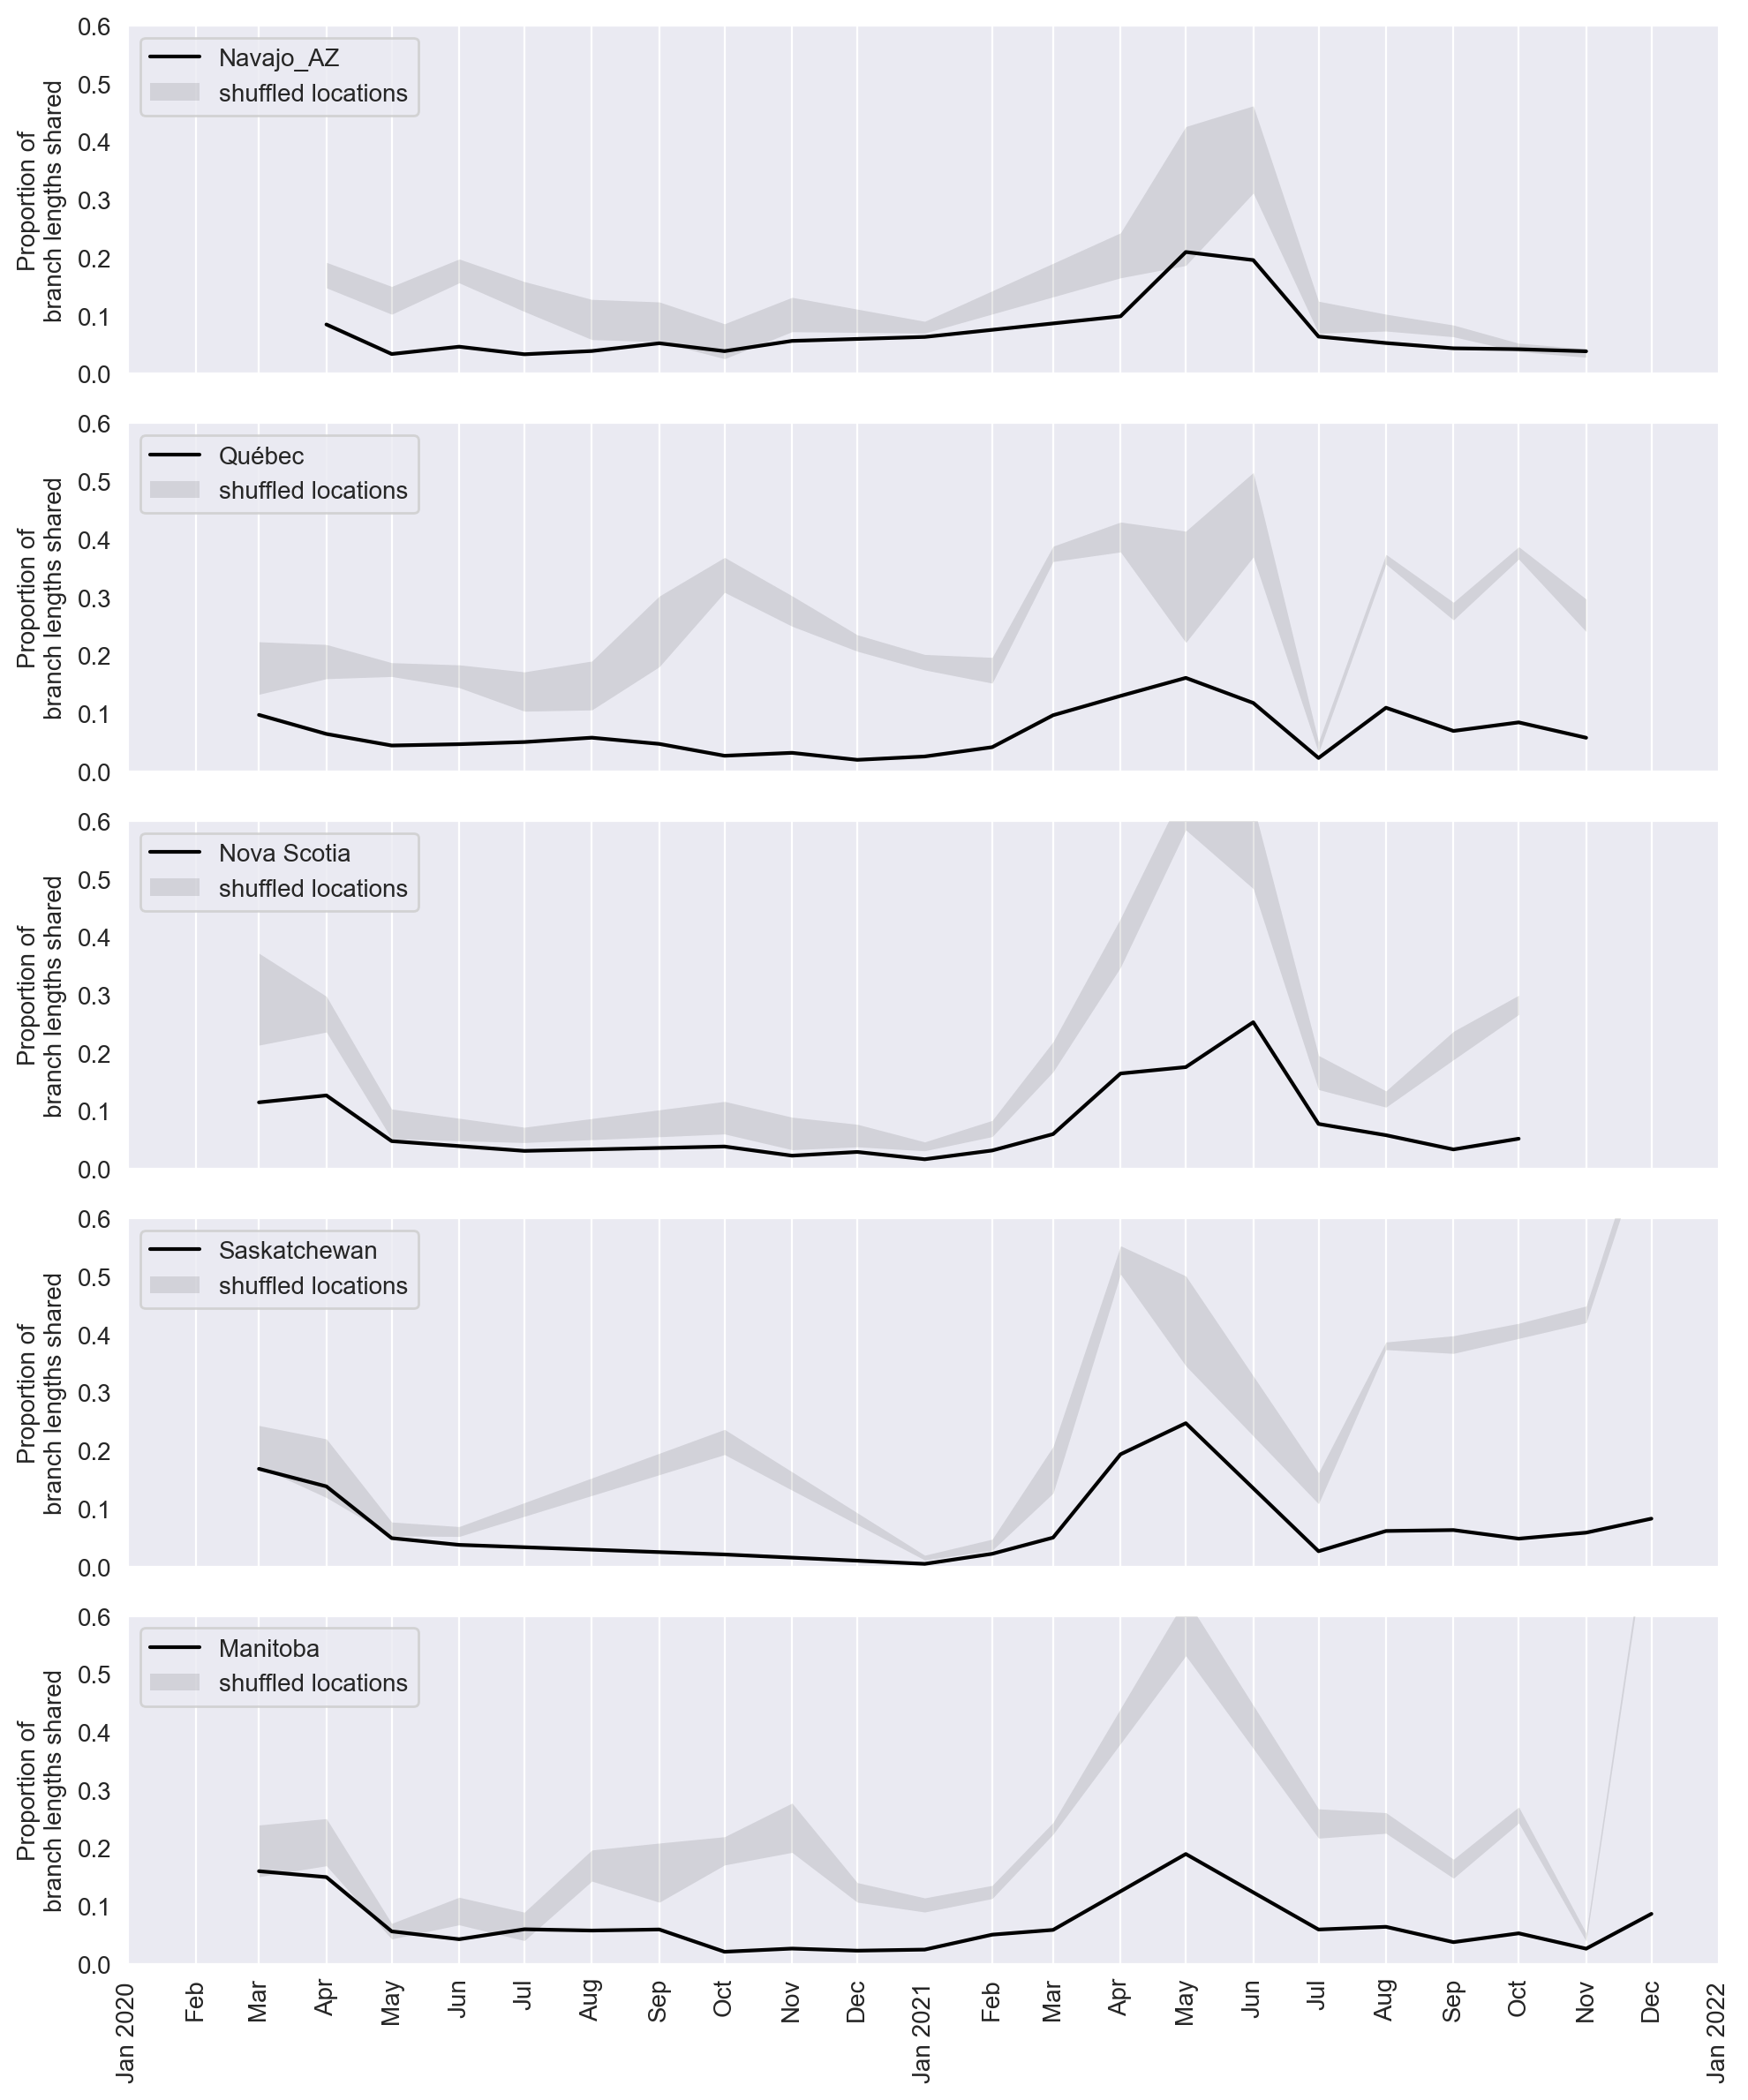

In [16]:
cor = correct_results( res, "value" )
fig, ax = plt.subplots( dpi=200, figsize=(10,12), nrows=5, sharey=True, sharex=True )
for i, loc in enumerate( orders.index[-5:] ):
    ax[i].fill_between( "date", "null_upper", "null_lower", data=cor.loc[cor["siteB"]==loc], color='black', alpha=0.1, zorder=90, linewidth=0, label="shuffled locations" )
    ax[i].plot( "date", "value", data=cor.loc[cor["siteB"]==loc], color="black", label=loc, zorder=100 )
    ax[i].legend( loc="upper left" )
    ax[i].set_ylim( 0, 0.6 )
    ax[i].set_ylabel( "Proportion of\nbranch lengths shared" )
    ax[i].grid( axis="both", which="both", zorder=0 )

ax[4].xaxis.set_major_locator( mdates.YearLocator() )
ax[4].xaxis.set_major_formatter( mdates.DateFormatter( "%b %Y" ))
ax[4].xaxis.set_minor_locator( mdates.MonthLocator() )
ax[4].xaxis.set_minor_formatter( mdates.DateFormatter( "%b" ))
ax[4].tick_params( axis="x", which="both", rotation=90 )
ax[4].set_xlim( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2022-01-01" ) )
plt.tight_layout()
#plt.savefig( "phylosor_top_null.pdf" )
plt.show()

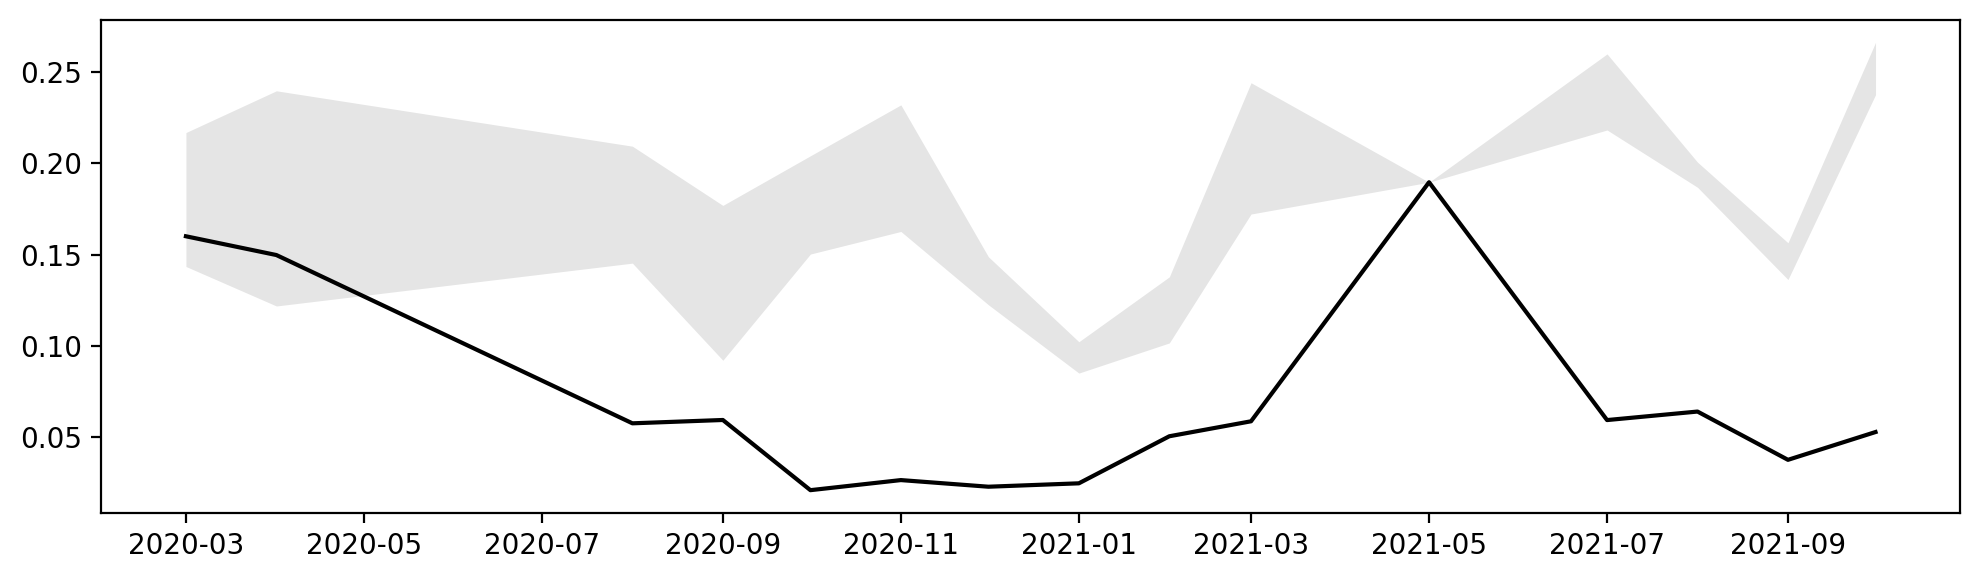

In [95]:
plot_df = correct_results( res, "value" ).query( "siteB=='Manitoba'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

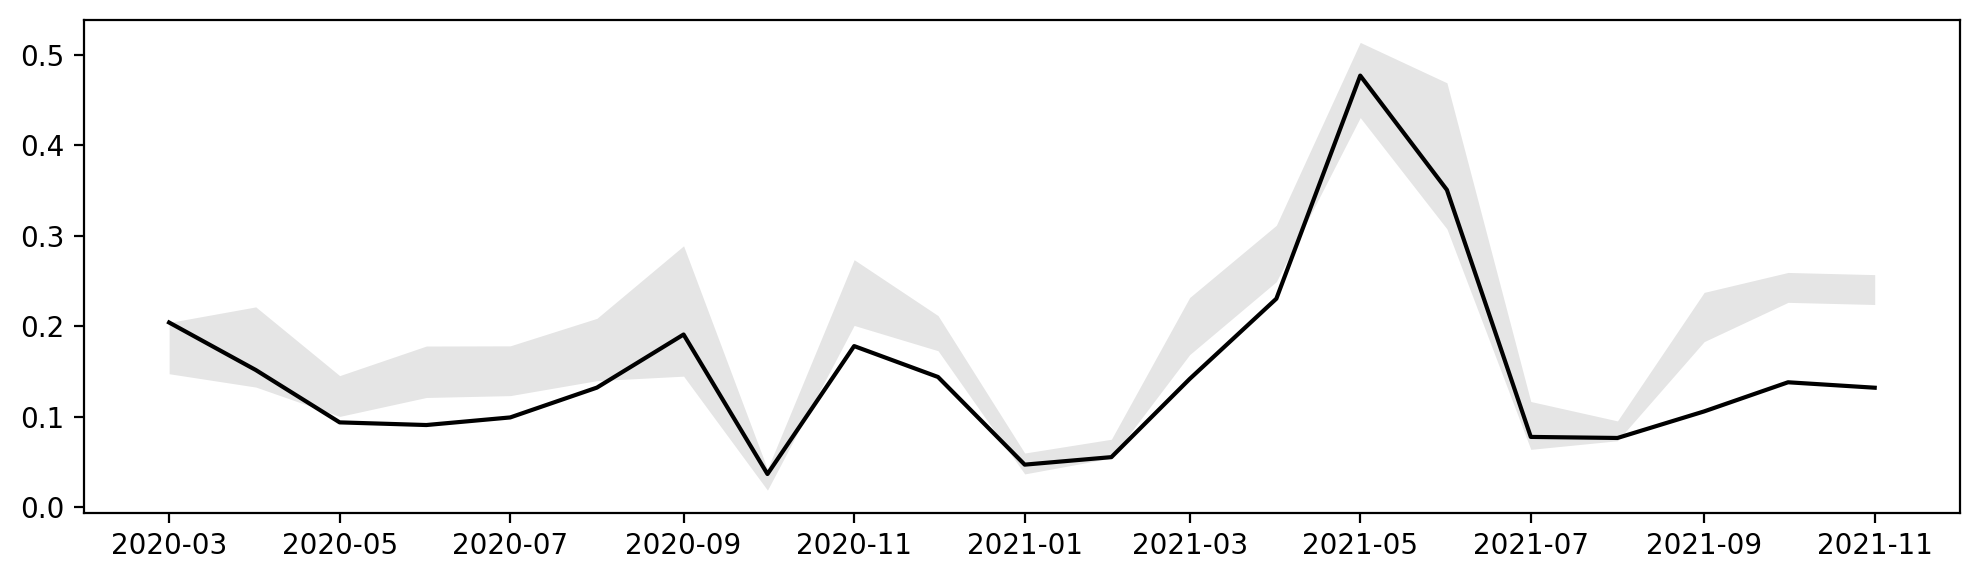

In [64]:
plot_df = correct_results( res, "value" ).query( "siteB=='Baja California'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black")
plt.tight_layout()
plt.show()

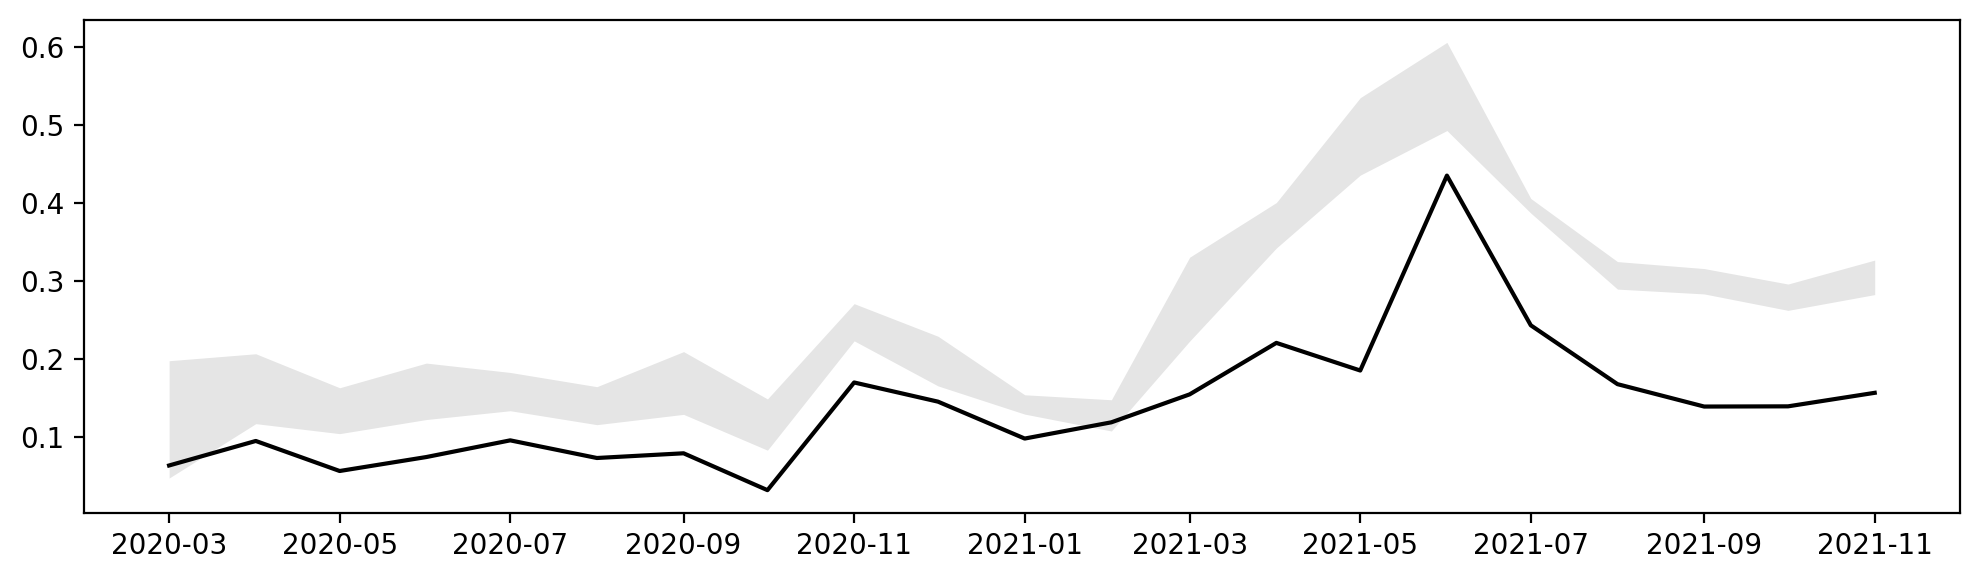

In [77]:
plot_df = correct_results( res, "value" ).query( "siteB=='Alameda_CA'")
fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
ax.fill_between( "date", "null_upper", "null_lower", data=plot_df, color='black', alpha=0.1, zorder=2, linewidth=0 )
ax.plot( "date", "value", data=plot_df, color="black" )
plt.tight_layout()
plt.show()

In [86]:
correct_results( res, "value" ).query( "siteB=='Baja California'")

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,kind,null_upper,null_lower,null_median,null_mean,null_std,corrected_sub,corrected_z
9538,0.005284,0.001338,0.000502,2020-04-01,San Diego_CA,46,Baja California,6,0.151515,0.375001,actual1,0.221568,0.132653,0.179105,0.178573,0.033062,0.070053,2.118827
9539,0.015851,0.003444,0.000903,2020-05-01,San Diego_CA,103,Baja California,21,0.093588,0.262136,actual1,0.145324,0.100173,0.129252,0.123053,0.016733,0.051736,3.091820
9540,0.017356,0.006254,0.001070,2020-06-01,San Diego_CA,90,Baja California,32,0.090652,0.171123,actual1,0.178056,0.121121,0.149615,0.149163,0.020543,0.087405,4.254724
9541,0.022841,0.005518,0.001405,2020-07-01,San Diego_CA,122,Baja California,32,0.099057,0.254546,actual1,0.178264,0.123174,0.153494,0.150970,0.019968,0.079207,3.966700
9542,0.014146,0.010166,0.001605,2020-08-01,San Diego_CA,45,Baja California,40,0.132050,0.157895,actual1,0.208671,0.139726,0.168576,0.172979,0.023770,0.076621,3.223483
9543,0.015483,0.004849,0.001940,2020-09-01,San Diego_CA,44,Baja California,12,0.190789,0.400000,actual1,0.288918,0.144698,0.231511,0.226372,0.047917,0.098129,2.047876
9545,0.044711,0.012407,0.005083,2020-11-01,San Diego_CA,153,Baja California,35,0.177986,0.409704,actual1,0.273557,0.200817,0.236326,0.236338,0.027598,0.095571,3.462988
9546,0.115607,0.021603,0.009865,2020-12-01,San Diego_CA,505,Baja California,69,0.143797,0.456657,actual1,0.211743,0.172843,0.192463,0.192174,0.013303,0.067946,5.107342
9547,0.240411,0.008059,0.005819,2021-01-01,San Diego_CA,1121,Baja California,15,0.046837,0.721992,actual1,0.059685,0.036542,0.052080,0.050061,0.008123,0.012848,1.581702
9548,0.132227,0.006053,0.003812,2021-02-01,San Diego_CA,577,Baja California,12,0.055139,0.629834,actual1,0.074934,0.054103,0.063563,0.064196,0.007405,0.019795,2.673374


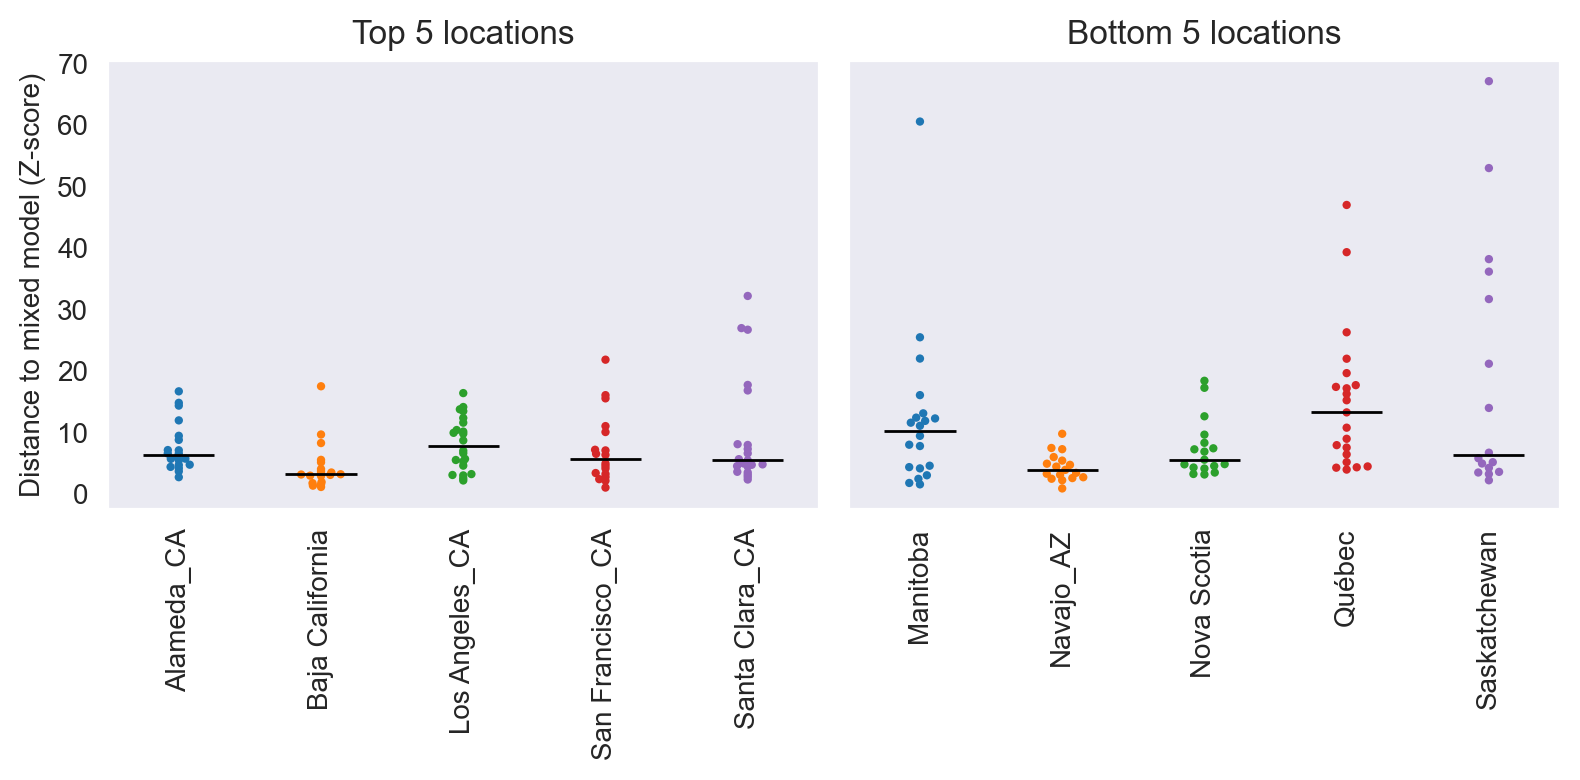

In [17]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )
plot_bottom = cor.loc[cor.index.isin( orders.index[-5:] )]
median_bot = plot_bottom.median( axis=1 ).reset_index().reset_index()
plot_bottom = plot_bottom.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

plot_top = cor.loc[cor.index.isin( orders.index[:5] )]
median_top = plot_top.median( axis=1 ).reset_index().reset_index()
plot_top = plot_top.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(8,4), ncols=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_top, size=3, ax=ax[0] )
ax[0].hlines( median_top[0], xmin=median_top["index"]-0.25, xmax=median_top["index"]+0.25, color="black", linewidth=1, zorder=100 )
sns.swarmplot( x="siteB", y="value", data=plot_bottom, size=3, ax=ax[1] )
ax[1].hlines( median_bot[0], xmin=median_bot["index"]-0.25, xmax=median_bot["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", which="both", rotation=90 )
ax[1].tick_params( axis="x", which="both", rotation=90 )
ax[0].set_xlabel( "" )
ax[1].set_xlabel( "" )
ax[0].set_title( "Top 5 locations" )
ax[1].set_title( "Bottom 5 locations" )
ax[0].grid( axis="y", zorder=0 )
ax[1].grid( axis="y", zorder=0 )

ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].label_outer()

plt.tight_layout()
#plt.savefig( "phylosor_mixing_z.pdf" )
plt.show()

In [18]:
def correct_results( entry, column ):
    a = entry.loc[entry["kind"].str.startswith("actual")]
    n = entry.loc[entry["kind"].str.startswith("null")]
    n = n.groupby( ["siteA", "siteB", "date"] )[column].agg(
        null_upper=lambda x: x.quantile( 0.975 ),
        null_lower=lambda x: x.quantile( 0.025 ),
        null_median="median",
        null_mean="mean",
        null_std="std" )
    a = a.merge( n, left_on=["siteA", "siteB", "date"], right_index=True, validate="1:1" )
    a["corrected_sub"] = a["null_upper"] - a[column]
    a["corrected_z"] = (a["null_upper"] - a[column]) / a["null_std"]
    return a

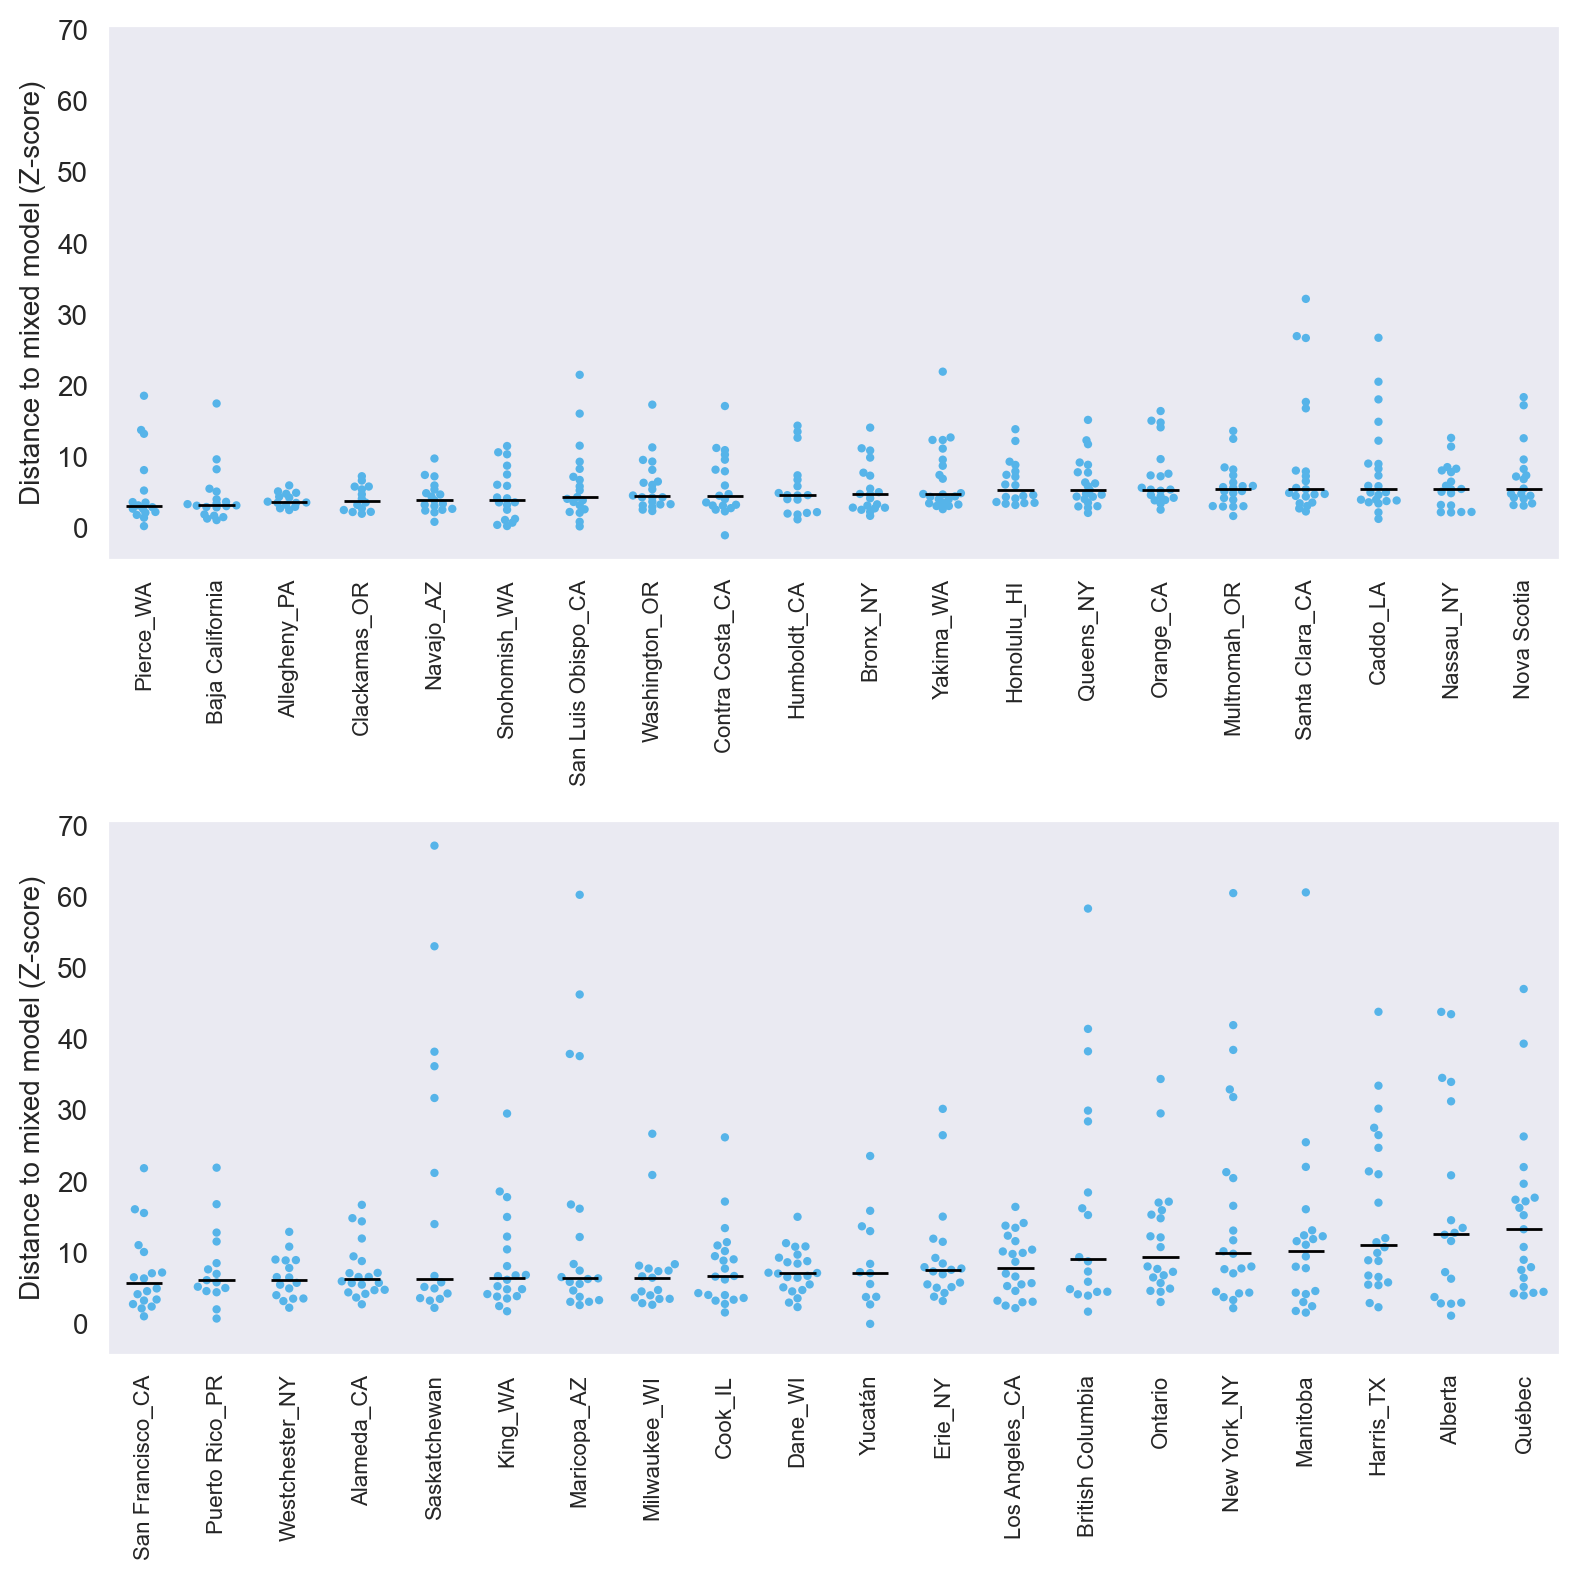

In [18]:
cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_z" )

cor = cor.reindex(index=cor.median(axis=1).sort_values( ascending=True ).index)

plot_df = cor.iloc[:20]
plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
plot_df2 = cor.iloc[20:]
plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
sns.swarmplot( x="siteB", y="value", data=plot_df, size=3, ax=ax[0], color="#56B4E9" )
sns.swarmplot( x="siteB", y="value", data=plot_df2, size=3, ax=ax[1], color="#56B4E9" )
ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )

ax[0].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[0].set_ylabel( "Distance to mixed model (Z-score)" )
ax[0].set_xlabel( "" )
#ax[0].set_title( f"Mean normalized PhyloSor" )
ax[0].grid( axis="y", zorder=1 )

ax[1].tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=8 )
ax[1].set_ylabel( "Distance to mixed model (Z-score)" )
ax[1].set_xlabel( "" )
ax[1].grid( axis="y", zorder=1 )

plt.tight_layout()
#plt.savefig( f"mixed_phylosor_all.pdf" )
plt.show()

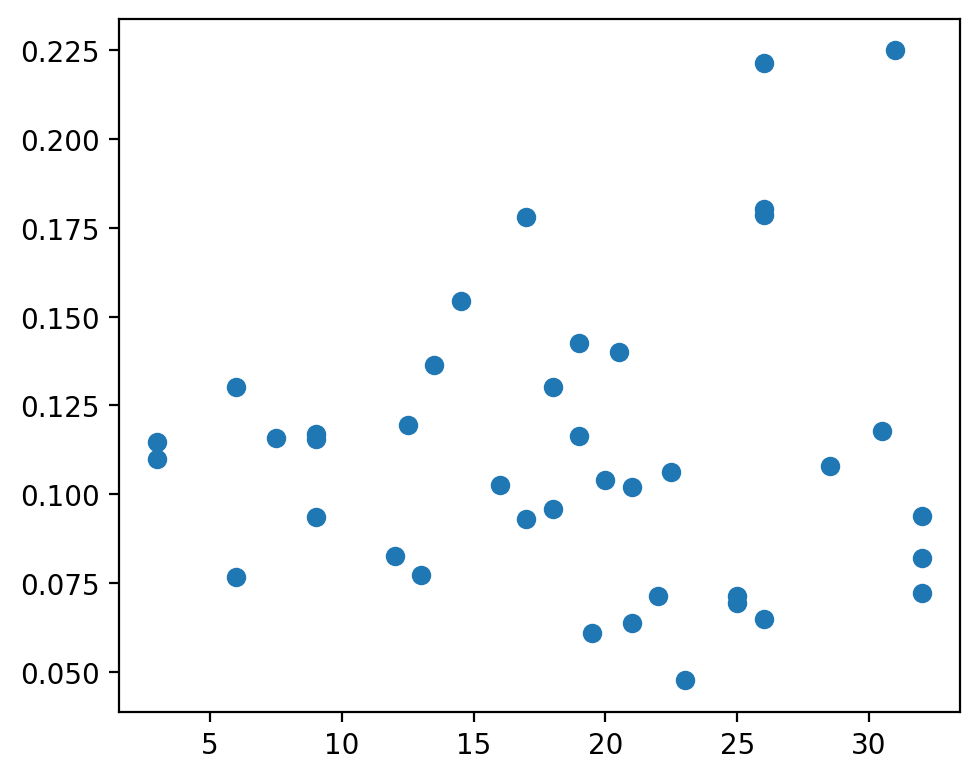

In [12]:
raw = res.loc[res["kind"]=="actual1"]
raw = raw.pivot( index="siteB", columns="date", values="value" )
orders = raw.rank( ascending=False )
orders = orders.reindex(index=orders.median(axis=1).sort_values().index)
phylosor_order = orders.median( axis=1 )

cor = correct_results( res, "value" )
cor = cor.pivot( index="siteB", columns="date", values="corrected_sub" )
null_order = cor.median( axis=1 )

plot_df = pd.concat( [phylosor_order, null_order], ignore_index=False, axis=1 )
plot_df.columns = ["phylosor_rank", "mixing"]

fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
ax.scatter( "phylosor_rank", "mixing", data=plot_df )
plt.tight_layout()
plt.show()